In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/okru-ml-junior/title_decode.pkl
/kaggle/input/okru-ml-junior/model.pkl
/kaggle/input/okru-ml-junior/title_encode.pkl
/kaggle/input/lastfm-music-artist-scrobbles/lastfm_user_scrobbles.csv
/kaggle/input/lastfm-music-artist-scrobbles/lastfm_artist_list.csv
/kaggle/input/nmslib-build-whl/nmslib-2.0.6-cp37-cp37m-manylinux2010_x86_64.whl


In [36]:
df1 = pd.read_csv('/kaggle/input/lastfm-music-artist-scrobbles/lastfm_user_scrobbles.csv')
df2 = pd.read_csv('/kaggle/input/lastfm-music-artist-scrobbles/lastfm_artist_list.csv')

In [37]:
print(df1.shape,'\n', df2.shape)

(92792, 3) 
 (17493, 2)


In [38]:
df1.head()

,user_id,artist_id,scrobbles
0,1,4562,13883
1,1,10191,11690
2,1,494,11351
3,1,6673,10300
4,1,8402,8983


Проверяем на дубликаты

In [39]:
df1.duplicated().sum()

3

In [40]:
df1[df1.duplicated(keep=False)]

,user_id,artist_id,scrobbles
23116,469,13613,12
23117,469,13613,12
42713,869,12385,1
42714,869,12385,1
73000,1488,11833,10
73001,1488,11833,10


Удаляем дубликаты

In [41]:
df1.drop_duplicates(inplace=True)

In [42]:
df2.head()

,artist_id,artist_name
0,1,__Max__
1,2,_Algol_
2,3,-123 Min.
3,4,-Oz-
4,5,-T De Sangre


Проверяем на дубликаты

In [43]:
df2.duplicated().sum()

0

In [44]:
newf = df1.pivot_table(index='user_id', columns='artist_id')
newf.columns = newf.columns.droplevel(0)

## Информация по scrobbles

In [45]:
df1.scrobbles.describe()

count     92789.000000
mean        745.545377
std        3752.204498
min           1.000000
25%         107.000000
50%         260.000000
75%         614.000000
max      352698.000000
Name: scrobbles, dtype: float64

График величин scrobbles

<AxesSubplot:>

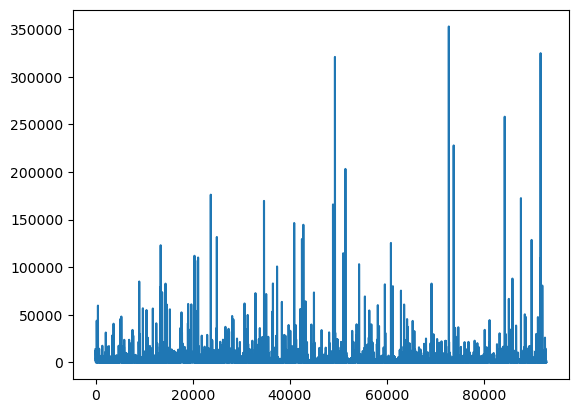

In [46]:
df1.scrobbles.plot()

## Информация по Users

In [47]:
newf.isna().sum(axis=1).describe()

count     1892.000000
mean     17443.992072
std          5.852356
min      17443.000000
25%      17443.000000
50%      17443.000000
75%      17443.000000
max      17492.000000
dtype: float64

График пустых значений для Users

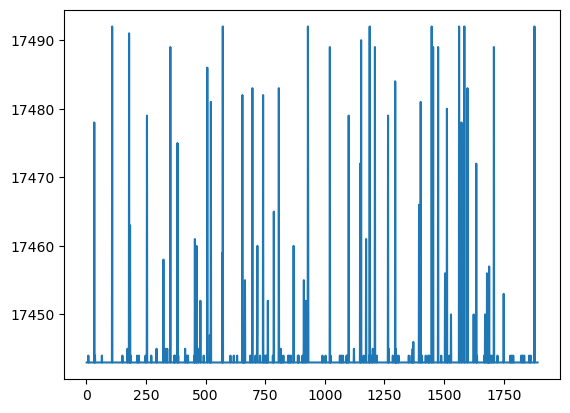

In [48]:
plt.plot(newf.isna().sum(axis=1))

## Информация по Items

Статистика по пустым значениям Items

In [49]:
newf.isna().sum(axis=0).describe()

count    17493.000000
mean      1886.699423
std         20.699653
min       1281.000000
25%       1889.000000
50%       1891.000000
75%       1891.000000
max       1891.000000
dtype: float64

## Матричная факторизация

In [50]:
from scipy import sparse
import implicit
from implicit.nearest_neighbours import bm25_weight
from operator import itemgetter
import pickle

In [51]:
# Словарь вида keys - имена исполнителей, values - id исполнителей
title_encode = dict(zip(df2.artist_name.tolist(),df2.artist_id.tolist()))
# Словарь вида keys - id исполнителей, values - имена исполнителей
title_decode = dict(zip(df2.artist_id.tolist(),df2.artist_name.tolist()))
# Получаем уникальные значения и индексы user_id и artist_id
rows, r_pos = np.unique(df1.values[:,0], return_inverse=True)
cols, c_pos = np.unique(df1.values[:,1], return_inverse=True)
# Строим разреженную матрицу user-to-items
interactions_sparse = sparse.csr_matrix((df1.values[:,2], (c_pos, r_pos)))

In [52]:
# Взвешиваем матрицу, чтобы уменьшить влияние пользователей,
# которые играли одного и того же исполнителя тысячи раз, и уменьшить вес,
# придаваемый популярным элементам
artist_user_plays = bm25_weight(interactions_sparse, K1=100, B=0.8)

# транспанируем матрицу, так как большинство функций в implicit ожидают (user-to-items) разреженную матрицах вместо (item-to-users)
user_plays = artist_user_plays.T.tocsr()

In [53]:
from tqdm import tqdm

# def memorize(func):
#     cache = {}
#     def wrapper(*args):
#         if args in cache:
#             return cache[args]
#         else:
#             result = func(*args)
#             cache[args] = result
#             return result
#     return wrapper

# @memorize
# def find_similar(artist_id,model):
#     return model.similar_items(artist_id-1, N=5, filter_items=[artist_id-1])

user_valid = df1.groupby('user_id')['artist_id'].apply(list).to_dict()

def accuracy(model):
    true_pred = 0
    total_pred = 0
    for user_id, artist_arr in tqdm(zip(user_valid.keys(),user_valid.values())):
        for artist_id in artist_arr:
            related, scores = model.similar_items(artist_id-1, N=5, filter_items=[artist_id-1])
            related +=1
            total_pred += len(related)
            true_pred+= len(set(related) & set(artist_arr))
#         print(true_pred, total_pred)
    return [(true_pred/total_pred) * 100, true_pred, total_pred]
                

### AlternatingLeastSquares

In [54]:
# инициализируем модель
model = implicit.als.AlternatingLeastSquares(factors=64, regularization=0.05, calculate_training_loss=True)

# обучаем модель на разреженной матрице с item/user/confidence весами
model.fit(user_plays)

  0%|          | 0/15 [00:00<?, ?it/s]

Warning NaN Detected in row 576 of 17493
Warning NaN Detected in row 1038 of 17493


In [55]:
# перемещаю модель на CPU, чтобы можно было запускать на машинах без GPU
model = model.to_cpu()

In [56]:
# сериализирую модель и декодер, энкодер, чтобы перемещать готовую модель между компьютерами
pickle.dump(model, open('model.pkl','wb'))
pickle.dump(title_encode, open('title_encode.pkl','wb'))
pickle.dump(title_decode, open('title_decode.pkl','wb'))

In [57]:
print(accuracy(model))

1892it [00:42, 44.69it/s]

[39.76441172983867, 184485, 463945]


### LogisticMatrixFactorization

In [58]:
# инициализируем модель
model = implicit.lmf.LogisticMatrixFactorization(factors=64, regularization=0.05)

# обучаем модель на разреженной матрице с item/user/confidence весами
model.fit(user_plays)

  0%|          | 0/30 [00:00<?, ?it/s]

In [59]:
print(accuracy(model))

1892it [00:47, 40.23it/s]

[22.865856944249856, 106085, 463945]


### NMSLibAlternatingLeastSquares

In [60]:
# инициализируем модель
model = implicit.bpr.BayesianPersonalizedRanking(factors=64, regularization=0.05, iterations=200)

# обучаем модель на разреженной матрице с item/user/confidence весами
model.fit(user_plays)

  0%|          | 0/200 [00:00<?, ?it/s]

In [61]:
print(accuracy(model))

1892it [00:17, 109.20it/s]

[21.093233034088094, 97861, 463945]


### NMSLibAlternatingLeastSquares

In [62]:
! pip install /kaggle/input/nmslib-build-whl/nmslib-2.0.6-cp37-cp37m-manylinux2010_x86_64.whl

Processing /kaggle/input/nmslib-build-whl/nmslib-2.0.6-cp37-cp37m-manylinux2010_x86_64.whl


In [63]:
# инициализируем модель
model = implicit.approximate_als.NMSLibAlternatingLeastSquares(factors=64, regularization=0.05, approximate_similar_items = True)

# обучаем модель на разреженной матрице с item/user/confidence весами
model.fit(user_plays)


Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


  0%|          | 0/15 [00:00<?, ?it/s]


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [64]:
print(accuracy(model))

1892it [00:15, 124.69it/s]

[39.77195572751081, 184520, 463945]
